In [27]:
import numpy as np
import pandas as pd
import json, os
import matplotlib.pyplot as plt 
from matplotlib import colors
from PIL import Image
import io
import random
import copy
import pickle

In [34]:
class ARC():
    def __init__(self,trn_dir='../data/training/',tes_dir='../data/evaluation/'):
        self.trn_dir,self.tes_dir=trn_dir,tes_dir
        self.trn_tasks=sorted(os.listdir(trn_dir))
        self.tes_tasks=sorted(os.listdir(tes_dir))
        self.cmap = colors.ListedColormap(
            ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00','#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
        self.norm = colors.Normalize(vmin=0, vmax=9)
    def get_task(self,taskid,kind='meta_train'):
        if kind=='meta_train':tdir,tsks=self.trn_dir,self.trn_tasks
        elif kind=='meta_test':tdir,tsks=self.tes_dir,self.tes_tasks
        task_file = tdir+tsks[taskid]
        with open(task_file,'r') as f: task=json.load(f)
        return task
    #plotting the training task and the test task.
    def plot_task(self,task,kind='orig',show=True):
        n = len(task["train"]) + len(task["test"])
        if kind=='orig':fig, axs = plt.subplots(2, n, figsize=(4*n,8), dpi=50)
        elif kind=='fewshot': fig, axs = plt.subplots(7, n, figsize=(6*n,12), dpi=100)
        plt.subplots_adjust(wspace=0, hspace=0)
        fig_num = 0
        cmap=self.cmap
        norm=self.norm
        for i, t in enumerate(task["train"]):
            if kind=='fewshot':t_in, t_out = np.array(t["input"]), t["output"]
            elif kind=='orig':t_in, t_out = np.array(t["input"]), np.array(t["output"])
            axs[0][fig_num].imshow(t_in, cmap=cmap, norm=norm)
            axs[0][fig_num].set_title(f'Train-{i} in')
            # axs[0][fig_num].set_yticks(list(range(t_in.shape[0])))
            # axs[0][fig_num].set_xticks(list(range(t_in.shape[1])))
            if kind=='orig':
                axs[1][fig_num].imshow(t_out, cmap=cmap, norm=norm)
                axs[1][fig_num].set_title(f'Train-{i} out')
                # axs[1][fig_num].set_yticks(list(range(t_out.shape[0])))
                # axs[1][fig_num].set_xticks(list(range(t_out.shape[1])))
            elif kind=='fewshot':
                for j in range(6):
                    if j==t['label']: iscorrect='CORRECT'
                    else: iscorrect=''
                    axs[j+1][fig_num].imshow(np.array(t_out[j]), cmap=cmap, norm=norm)
                    axs[j+1][fig_num].set_title(f'Out-{i},{j} '+iscorrect)
                    # axs[j+1][fig_num].set_yticks(list(range(np.array(t_out[j]).shape[0])))
                    # axs[j+1][fig_num].set_xticks(list(range(np.array(t_out[j]).shape[1])))
            fig_num += 1
        for i, t in enumerate(task["test"]):
            if kind=='fewshot':t_in, t_out = np.array(t["input"]), t["output"]
            elif kind=='orig':t_in, t_out = np.array(t["input"]), np.array(t["output"])
            axs[0][fig_num].imshow(t_in, cmap=cmap, norm=norm)
            axs[0][fig_num].set_title(f'Test-{i} in')
            # axs[0][fig_num].set_yticks(list(range(t_in.shape[0])))
            # axs[0][fig_num].set_xticks(list(range(t_in.shape[1])))
            if kind=='orig' and show:
                axs[1][fig_num].imshow(t_out, cmap=cmap, norm=norm)
                axs[1][fig_num].set_title(f'Test-{i} out')
                # axs[1][fig_num].set_yticks(list(range(t_out.shape[0])))
                # axs[1][fig_num].set_xticks(list(range(t_out.shape[1])))
            elif kind=='fewshot' and show:
                for j in range(6):
                    if j==t['label']: iscorrect='CORRECT'
                    else: iscorrect=''
                    axs[j+1][fig_num].imshow(np.array(t_out[j]), cmap=cmap, norm=norm)
                    axs[j+1][fig_num].set_title(f'Test-{i},{j} '+iscorrect)
                    # axs[j+1][fig_num].set_yticks(list(range(np.array(t_out[j]).shape[0])))
                    # axs[j+1][fig_num].set_xticks(list(range(np.array(t_out[j]).shape[1])))
            fig_num += 1
        plt.tight_layout()
        plt.show()
    def example2img(self,example):
        shp=np.array(example).shape
        fig=plt.Figure(figsize=(.5*shp[0],.5*shp[1]))
        ax = fig.add_subplot()
        cmap,norm=self.cmap,self.norm
        ax.imshow(np.array(example), cmap=cmap, norm=norm)
        """Convert a Matplotlib figure to a PIL Image and return it"""
        buf = io.BytesIO()
        fig.savefig(buf)
        buf.seek(0)
        img = Image.open(buf)
        return img
    def example2numpy(self,example):
        return np.array(example)

In [33]:
class FewShotARC(ARC):
    def __init__(self,trn_dir='../data/training/',tes_dir='../data/evaluation/',ways=6):
        super().__init__(trn_dir='../data/training/',tes_dir='../data/evaluation/')
        self.nrand=ways-1
        self.ntrain=len(self.trn_tasks)
        self.ntest=len(self.tes_tasks)
        self.meta_train_tasks=[]
        self.meta_test_tasks=[]
    def create_tasks(self,kind='meta_train'):
        if kind=='meta_train':ntasks=self.ntrain
        elif kind=='meta_test':ntasks=self.ntest
        for i in range(ntasks):
            task=self.get_task(i,kind=kind)
            nex=len(task['train'])
            for k in range(nex):
                rexamples=self.add_rand(i,kind=kind)
                label=random.randint(0,self.nrand)
                task['train'][k]['output']=rexamples[0:label]+[task['train'][k]['output']]+rexamples[label:self.nrand]
                task['train'][k]['label']=label
            rexamples=self.add_rand(i,kind=kind)
            label=random.randint(0,self.nrand)
            task['test'][0]['output']=rexamples[0:label]+[task['test'][0]['output']]+rexamples[label:self.nrand]
            task['test'][0]['label']=label
            if kind=='meta_train': self.meta_train_tasks+=[task]
            elif kind=='meta_test': self.meta_test_tasks+=[task]
        return
    def get_rand_example(self,taskid,kind='meta_train'):
        task=self.get_task(taskid,kind=kind)
        if random.randint(0,1)==0:trte='train'
        else: trte='test'
        if random.randint(0,1)==0:inout='input'
        else: inout='output'
        examples=task[trte]
        nex=len(examples)
        rint=random.randint(0,nex-1)
        example=examples[rint][inout]
        return example
    def add_rand(self,taskid,kind='meta_train'):
        if kind=='meta_train':n=self.ntrain
        elif kind=='meta_test':n=self.ntest
        tlist=[taskid]
        rand_examples=[]
        for i in range(self.nrand):
            rid=random.randint(0,n-1)
            while rid in tlist: rid=random.randint(0,n-1)
            rand_examples+=[self.get_rand_example(rid,kind=kind)]
            tlist+=[rid]
        return rand_examples
    def get_fs_task(self,taskid,kind='meta_train'):
        if kind=='meta_train': return self.meta_train_tasks[taskid]
        elif kind=='meta_test': return self.meta_test_tasks[taskid]
    def get_examples(self,taskid,trte,inout,kind='meta_train'):
        # if kind=='meta_train':taskL=self.meta_train_tasks
        # elif kind=='meta_test':taskL=self.meta_test_tasks
        # return [taskL[taskid][trte][k][inout] for k in range(len(taskL[taskid][trte]))]
        if kind=='meta_train':taskL=[self.get_task(taskid,kind) for taskid in self.ntrain]
        elif kind=='meta_test':taskL=[self.get_task(taskid,kind) for taskid in self.ntrain]
        return [taskL[taskid][trte][k][inout] for k in range(len(taskL[taskid][trte]))]

In [41]:
arc = ARC()

In [43]:
task = arc.get_task(0)

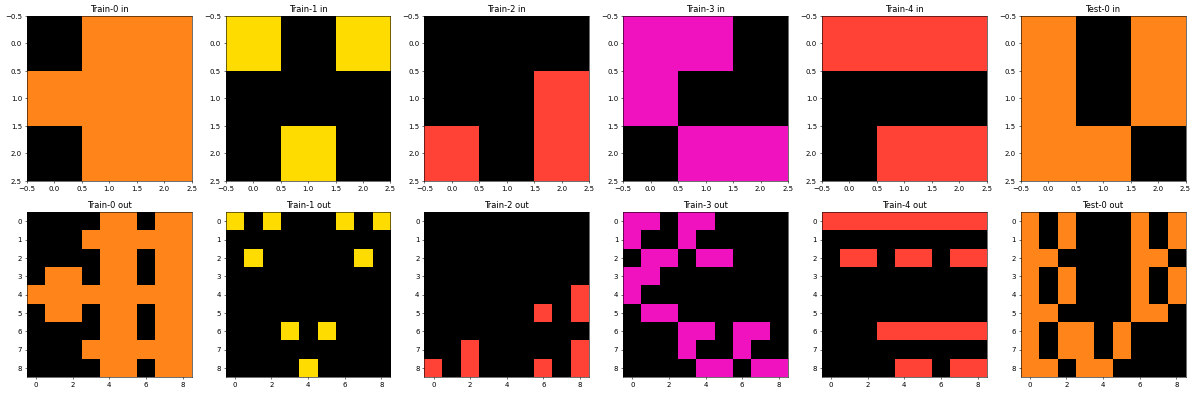

In [48]:
arc.plot_task(task)